## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
import time
import os

In [2]:
os.chdir("..")
# path = os.getcwd()
# os.chdir(path)
os.getcwd()

'/Users/Albert/Dropbox/NU_2023_Winter/GitHub/Geriatrics'

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data Preparation

*By Kegan Grace and Albert Wang*

Our dataset was a collection of csv files for each decade from 1950-2019, so we needed to concatenate all the files together to expand our dataset and number of observations.

In [3]:
# import data
df1 = pd.read_csv('Kaggle Data/1950.xls')
df2 = pd.read_csv('Kaggle Data/1960.xls')
df3 = pd.read_csv('Kaggle Data/1970.xls')
df4 = pd.read_csv('Kaggle Data/1980.xls')
df5 = pd.read_csv('Kaggle Data/1990.xls')
df6 = pd.read_csv('Kaggle Data/2000.xls')
df7 = pd.read_csv('Kaggle Data/2010.xls')

# merge data into one dataset
df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=0)
df.shape

(667, 15)

In [8]:
# Splitting data into train and test sets
from sklearn.model_selection import train_test_split
X = df.drop('pop', axis=1)
y = df['pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.shape, test.shape

((533, 15), (134, 15))

### Data quality check
*By Grant Li*

Checking VIF for multicollinearity

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['bpm', 'dB', 'dnce', 'nrgy', 'acous', 'dur', 'val', 'spch', 'live']]

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

  feature         VIF
0   const  124.800224
1     bpm    1.085976
2      dB    2.256884
3    dnce    1.591783
4    nrgy    3.455843
5   acous    2.068433
6     dur    1.126420
7     val    1.667733
8    spch    1.088994
9    live    1.054143


## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

*By Albert Wang and Grant Li*

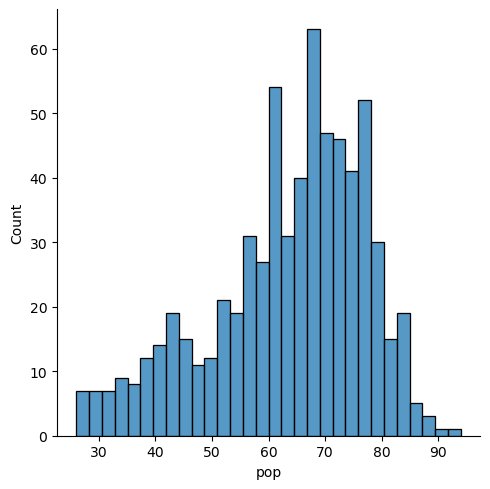

In [6]:
#histogram to show distribution of song popularity values
sns.displot(df['pop'], bins=30)
plt.show()

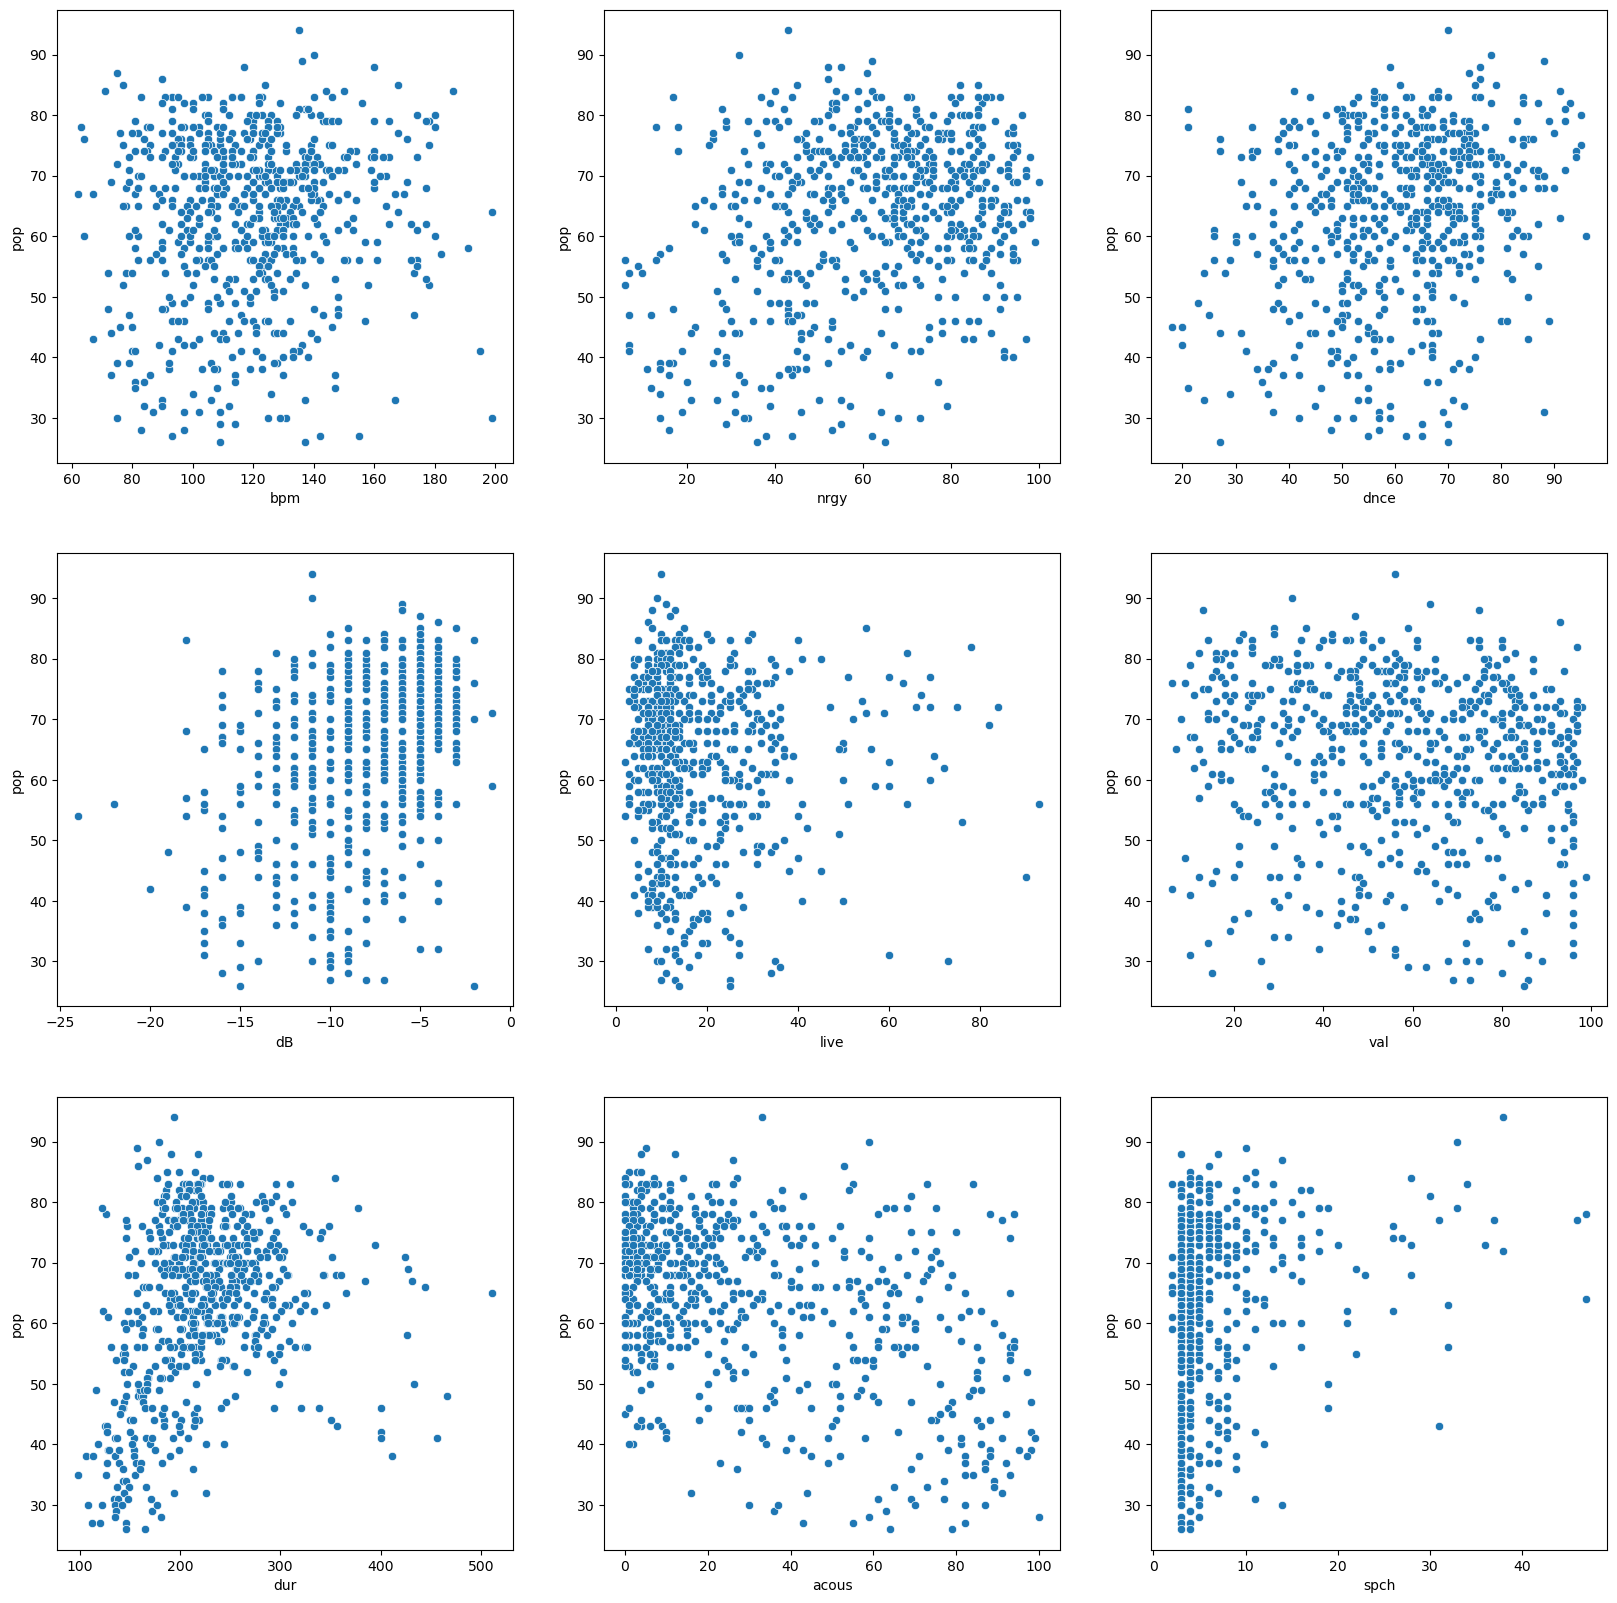

In [9]:
#visualizations of all numerical variables (including non-audial features) agaisnt song popularity
X = df[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch']]
fig, axes = plt.subplots(3,3,figsize=(20,20))
p = 0
for i in range(3):
    for j in range(3):
        
        if p >= 9:
            break
        predictor = X.iloc[:,p]
        
        sns.scatterplot(ax=axes[i,j], x=predictor,y='pop',data=df)
        p+=1
plt.show()

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Forward Stepwise Variable Selection
*By Grant Li*

### Model Testing - Transformations and Interactions
*By Nate Kim*

In [ ]:
# baseline model
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+val', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

#### Testing transformations on duration

In [ ]:
#model with **2 transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(dur**2)', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

#model with log transformation on duration
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.log(dur))', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

# model with sqrt tranformation on dur
model = smf.ols(formula='pop~acous+dB+dur+dnce+nrgy+I(np.sqrt(dur))', data=train).fit()
print(model.summary())
#test MAE
pred_pop = model.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [ ]:
model_best = smf.ols(formula='pop~acous+dB+dur+nrgy*dnce+val+I(np.log(dur))', data=train).fit()
print(model_best.summary())
#test MAE
pred_pop = model_best.predict(test)
mae = (np.abs(test['pop'] - pred_pop)).mean()
print("Test MAE is", mae)
#train MAE
mae_train = (np.abs(train['pop'] - pred_pop)).mean()
print("Train MAE is",mae_train)

In [ ]:
#outliers
sns.scatterplot(x=model_best.fittedvalues, y=model_best.resid, color='orange')
sns.lineplot(x=[pred_pop.min(),pred_pop.max()], y=[0,0],color='blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Residual')
plt.show()

In [ ]:
out = model_best.outlier_test()
# returns a df w the first col as studentized residuals
# res plot, this time w studentized residuals
sns.scatterplot(x=model_best.fittedvalues, y = out.student_resid, color='orange')
sns.lineplot(x = [model_best.fittedvalues.min(),model_best.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Predicted popularity')
plt.ylabel('Studentized residuals')
plt.show()

In [ ]:
print(np.sum(np.abs(out.student_resid) > 3)) # 3 outliers

In [ ]:
# leverage calculations
influence = model_best.get_influence()
leverage = influence.hat_matrix_diag
cutoff = 4*(model_best.df_model+1)/model_best.nobs
print(np.sum(leverage>cutoff)) #6 high leverage points

In [ ]:
#Dropping influential points from data
train_filtered = train.drop(np.intersect1d(np.where(np.abs(out.student_resid)>3)[0],
                                           (np.where(leverage>cutoff)[0])))
train_filtered.shape[0]-train.shape[0]
#no influential points

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.